# Example of how to use the adaptive decomposition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from pathlib import Path

from adapt_decomp.loaders import load_example, load_neuromotion
from adapt_decomp.adaptation import AdaptDecomp
from adapt_decomp.config import Config
from adapt_decomp.plots import plot_sep_vectors_diff, plot_whitening_comp, plot_sep_vectors_comp
from adapt_decomp.utils import rate_of_agreement_paired, rate_of_agreement, get_coefficient_of_variation, get_discharge_rate, get_pulse_to_noise_ratio, get_silhouette_measure
from adapt_decomp.io import load_output

%load_ext autoreload
%autoreload 2

sns.set_theme(style='whitegrid', font_scale=1.1)

## 1. Input data
The `AdaptDecomp` module requires:
- An EMG dataset
- Precalibrated decomposition model based on static conditions including
    - EMG during calibration
    - extension factor
    - whitening 
    - separation vectors
    - spike/baseline centroids
    - outputted IPTs
    - outputted spikes

The code uses the EMG during calibration and outputted spikes and IPTs to compute the covariance matrix of the whitenined EMG signals during calibration and the mean values of the contrast function (logcosh, cube) of the sources during calibration to calculate the whitening and separation losses (median squared error between the KL-divergence and estimated kurtosis of the adaptation and calibration conditions).
    
This notebook applies the decomposition adaptation to a wrist dynamic contraction simulated with [NeuroMotion](https://github.com/shihan-ma/NeuroMotion). The EMG signals were simulated from the forearm (band of 10 rows and 32 columns) during an index flexion (FDS muscle activated at 15% MVC) while the wrist flexed from 0 degrees to -40 degrees in a staircase pattern (30 s plateaus, 10 s ramps at 1deg/s). The first plateau is used to precalibrate a convolutive blind source separation model that is adapted for the rest of the contraction.

Load the simulated dataset and the corresponding decomposition during the calibration segment.

In [ ]:
# Load data
path_emg = Path('..', 'data', 'example', 'data_sim.hdf5')
path_decomp = Path('..', 'data', 'example', 'decomp_sim.mat')

data = load_example(path_emg, path_decomp, False)
print(data.keys())

dict_keys(['emg', 'timestamps', 'fs', 'force_profile', 'angle_profile', 'ch_map', 'whitening', 'sep_vectors', 'base_centr', 'spikes_centr', 'ext_fact', 'emg_calib', 'ipts_calib', 'spikes_calib', 'spikes_gt', 'preprocess'])


Take a look at the data

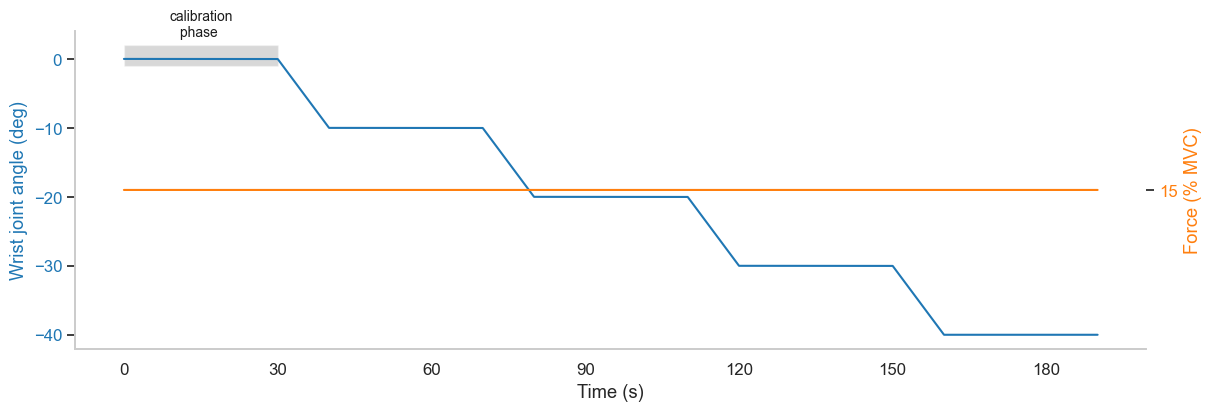

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,4), layout='constrained')

axs.add_patch( Rectangle((0,-1), 30, 3, facecolor='grey', edgecolor=None, alpha=0.3) )
axs.text(15, 5, 'calibration\nphase ', dict(ha='center', va='center', fontsize=10, color='k'))
axs.plot(data['timestamps'], data['angle_profile'], color='tab:blue')
axs.tick_params(axis='y', labelcolor='tab:blue')
axs.set_ylabel('Wrist joint angle (deg)', color='tab:blue')
axs.set_xlabel('Time (s)')
axs.grid(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs1 = axs.twinx()
axs1.plot(data['timestamps'], data['force_profile'], color='tab:orange')
axs1.tick_params(axis='y', labelcolor='tab:orange')
axs1.set_ylabel('Force (% MVC)', color='tab:orange')
axs1.spines['top'].set_visible(False)
axs1.spines['right'].set_visible(False)
axs1.set(xticks=range(0,191,30), yticks=[15])
axs1.grid(False)

plt.show()

## 2. Apply decomposition without adaptation

In [4]:
# Define configuration
config = Config()
# Override needed parameters
config.ext_fact = data['ext_fact']
config.adapt_wh = False     # Deactivate whitening adapataion
config.adapt_sv = False     # Deactivate separation vector adaptation
config.adapt_sd = False     # Deactivate spike detection adaptation
config.compute_loss = True  # For faster execution, set to False

# Run decomposition
dyndec_no_adapt = AdaptDecomp(
    emg = data['emg'].clone(),
    whitening = data['whitening'].clone(),
    sep_vectors = data['sep_vectors'].clone(),
    base_centr = data['base_centr'].clone(),
    spikes_centr = data['spikes_centr'].clone(),
    emg_calib = data['emg_calib'].clone(),
    ipts_calib = data['ipts_calib'].clone(),
    spikes_calib = data['spikes_calib'].clone(),
    preprocess = data['preprocess'],
    config = config
    )
outputs_no_adapt = dyndec_no_adapt.run()

print('Decomposition without adaptation done!')

Decomposition without adaptation done!


## 3. Apply decomposition with adaptation

In [5]:
# Define configuration
config = Config()
# Override needed parameters
config.ext_fact = data['ext_fact']
config.compute_loss = True  # For faster execution, set to False
# Save parameters
path_out_adapt = Path('..', 'data', 'example', 'decomp_adapt_out.hdf5')
config.save_params = True 


# Run decomposition
dyndec_adapt = AdaptDecomp(
    emg = data['emg'].clone(),
    whitening = data['whitening'].clone(),
    sep_vectors = data['sep_vectors'].clone(),
    base_centr = data['base_centr'].clone(),
    spikes_centr = data['spikes_centr'].clone(),
    emg_calib = data['emg_calib'].clone(),
    ipts_calib = data['ipts_calib'].clone(),
    spikes_calib = data['spikes_calib'].clone(),
    preprocess = data['preprocess'],
    config = config,
    save_path = path_out_adapt
    )
outputs_adapt = dyndec_adapt.run()

print('Decomposition with adaptation done!')

Decomposition with adaptation done!


In [ ]:
# Load data
path_out_adapt = Path('..', 'data', 'example', 'decomp_adapt_out.hdf5')
params_adapt = load_output(path_out_adapt)
print(params_adapt.keys())

dict_keys(['base_centr', 'ipts', 'sd_time_ms', 'sep_vectors', 'spikes', 'spikes_centr', 'sv_loss', 'sv_time_ms', 'total_loss', 'total_time_ms', 'wh_loss', 'wh_time_ms', 'whitening'])


In [ ]:
print(params_adapt['whitening'].shape)
print(params_adapt['sep_vectors'].shape)
print(params_adapt['base_centr'].shape)
print(params_adapt['spikes_centr'].shape)
print(params_adapt['wh_loss'].shape)
print(params_adapt['sv_loss'].shape)

(1908, 960, 960)
(1908, 18, 960)
(1908, 18)
(1908, 18)
(1908,)
(1908, 18)


In [ ]:
# Plit changes in separation vectors
source = 0  # Select source to plot
samples = np.arange(0, params_adapt['sep_vectors'].shape[0], 10)

# Colour map
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=samples.min(), vmax=samples.max())

fig, axs = plt.subplots(1,1, figsize=(12,5), layout='constrained')
for s in samples:
    sv = params_adapt['sep_vectors'][s,source]
    axs.plot(sv, color=cmap(norm(s)), label=f'Sample {s}')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Sample index', rotation=270, labelpad=15)
axs.set_title(f'Adaptation of separation vector for source {source}')
axs.set_xlabel('Channel')
axs.set_ylabel('Amplitude (a.u.)')
plt.show()

ValueError: 10 is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

Error in callback <function _draw_all_if_interactive at 0x000001CF5F07EB90> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## 4. Evaluate execution time per batch and method
Note: for faster execution times for real-time interfacing, disable the computation of the loss (`config.compute_loss = False`). The loss is only needed to optimise the hyperparameters of the decomposition (whitening and separation vectors learning rate), but it is not used during the adaptation.

In [6]:
# CPU with loss calculaion
title = 'No adaptation'
print(title + '\n' + '-'*len(title))
for key in ['wh_time_ms', 'sv_time_ms', 'sd_time_ms', 'total_time_ms']:
    if key != 'method':
        print(f'{key:>15}: {outputs_no_adapt[key].mean():.3f} ± {outputs_no_adapt[key].std():.3f} ms')

title = 'Adaptation'
print('\n' + title + '\n' + '-'*len(title))
for key in ['wh_time_ms', 'sv_time_ms', 'sd_time_ms', 'total_time_ms']:
    if key != 'method':
        print(f'{key:>15}: {outputs_adapt[key].mean():.3f} ± {outputs_adapt[key].std():.3f} ms')

No adaptation
-------------
     wh_time_ms: 4.320 ± 1.373 ms
     sv_time_ms: 0.757 ± 0.278 ms
     sd_time_ms: 0.815 ± 0.102 ms
  total_time_ms: 5.892 ± 1.448 ms

Adaptation
----------
     wh_time_ms: 6.781 ± 1.533 ms
     sv_time_ms: 2.501 ± 0.496 ms
     sd_time_ms: 0.865 ± 0.055 ms
  total_time_ms: 10.147 ± 1.634 ms


## 5. Evaluate the adaptation effect
To evaluate the effect of the adaptation we can take a look at the whitening and separation vector losses, defined as the median squared error between the Kulback-Leibler divergence of the whitened covariance during calibration and adaptation, and the median squared error between the contrast functions during the calibration and the adaptation, respectively.

Note how without adaptation the whitening loss increases following the same trend as the deviation in wrist joint angle, and how most of the spikes are lost after 10 degrees.

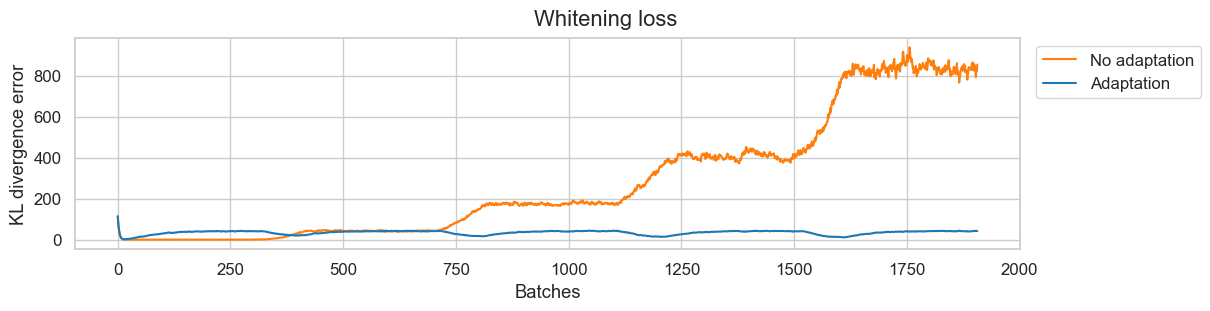

In [7]:
colors = ['tab:orange', 'tab:blue']

# Check the KL divergence error
fig, axs = plt.subplots(1, 1, figsize=(12, 3), layout='constrained')
axs.plot(outputs_no_adapt['wh_loss'][:-1], label='No adaptation', color=colors[0])
axs.plot(outputs_adapt['wh_loss'][:-1], label='Adaptation', color=colors[1])
axs.set(xlabel='Batches', ylabel='KL divergence error')
axs.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.suptitle('Whitening loss')
plt.show()

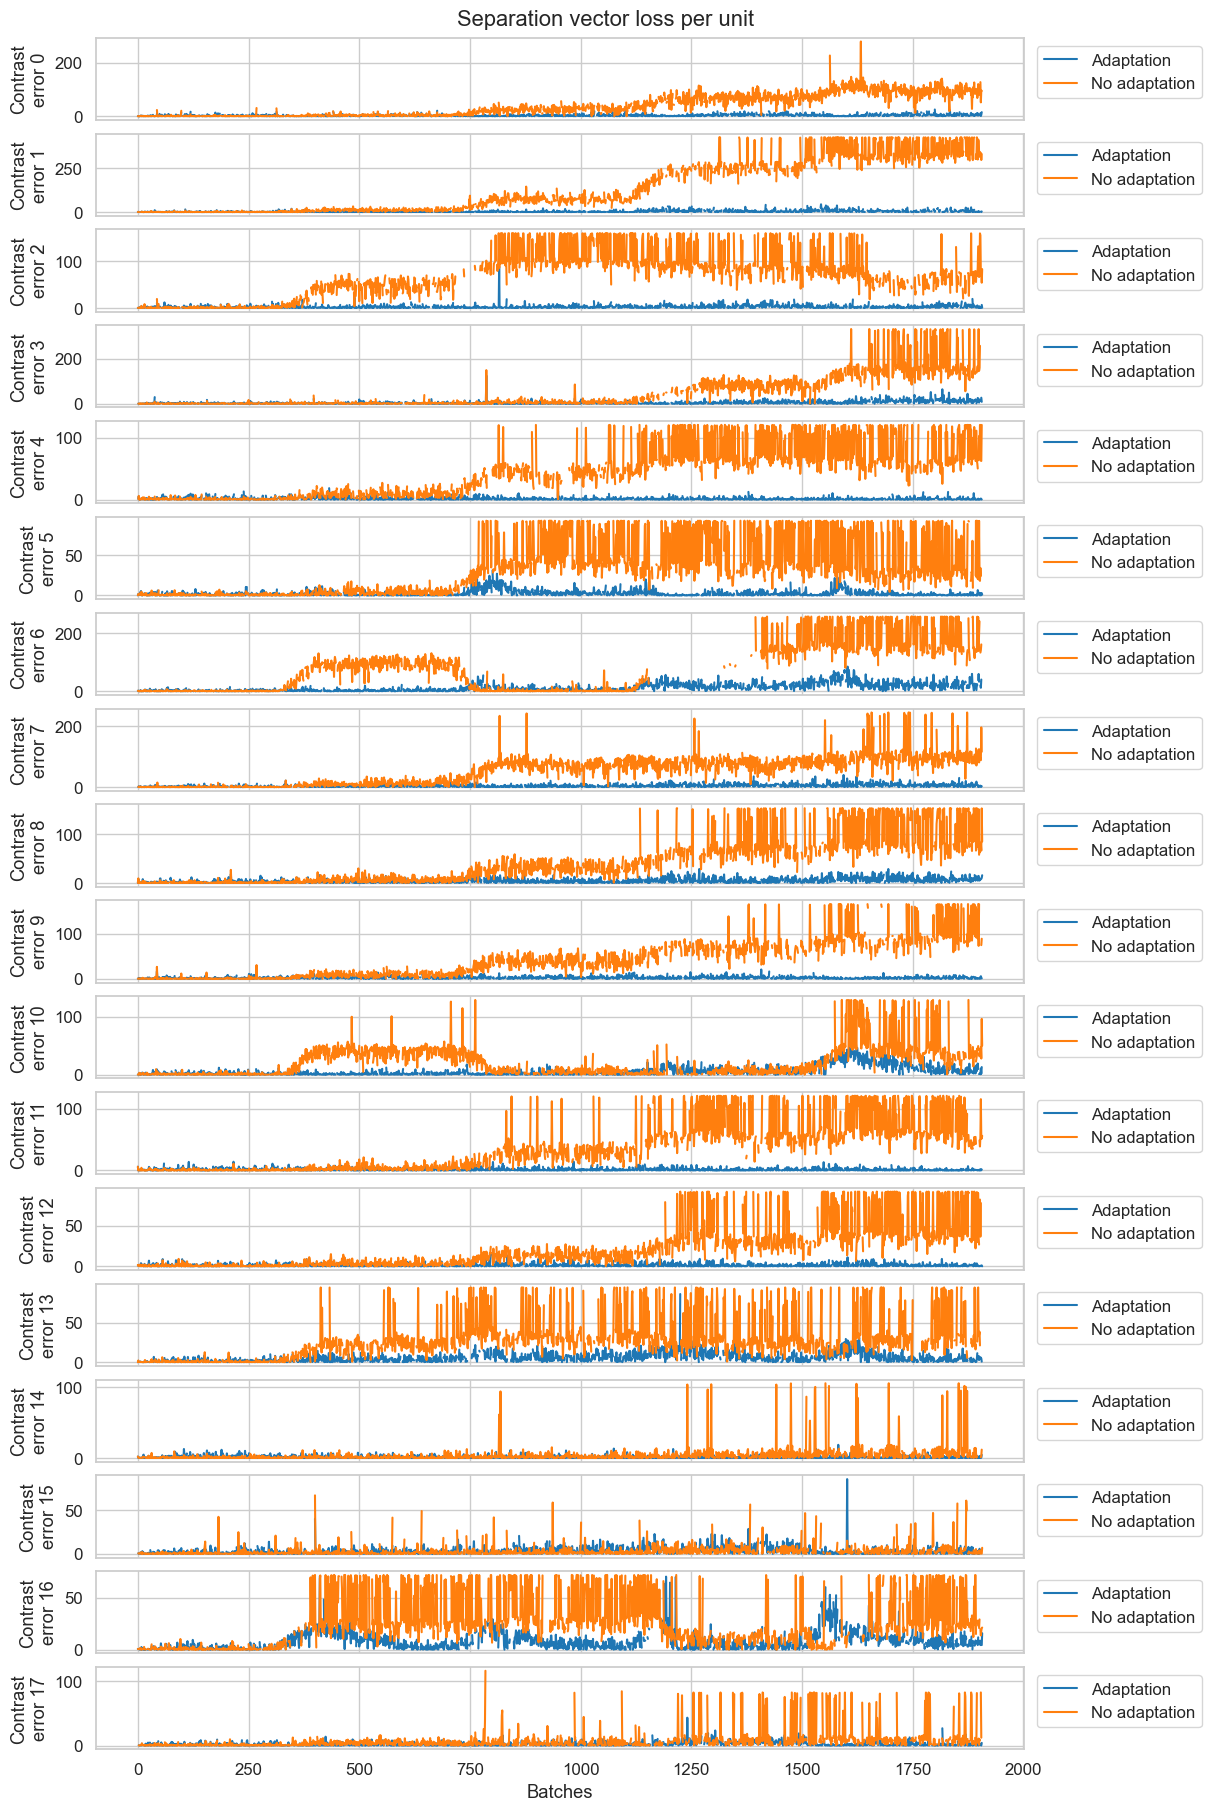

In [8]:
units = len(data['spikes_centr'])
fig, axs = plt.subplots(units, 1, figsize=(12, units), layout='constrained', sharex=True)

for unit in range(units):
    axs[unit].plot(outputs_adapt['sv_loss'][:,unit], label='Adaptation', color=colors[1])
    axs[unit].plot(outputs_no_adapt['sv_loss'][:,unit], label='No adaptation', color=colors[0])
    axs[unit].set(ylabel=f'Contrast\nerror {unit}')
    axs[unit].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    if unit == units-1:
        axs[unit].set(xlabel='Batches')

plt.suptitle('Separation vector loss per unit') 
plt.show()

## 6. Plot IPTs and spikes

Now let's plot the spike trains at the maximum angle deviation with and without adaptation. Notice how adaptation recovers almost all of the spikes that were lost with the change in joint angle.

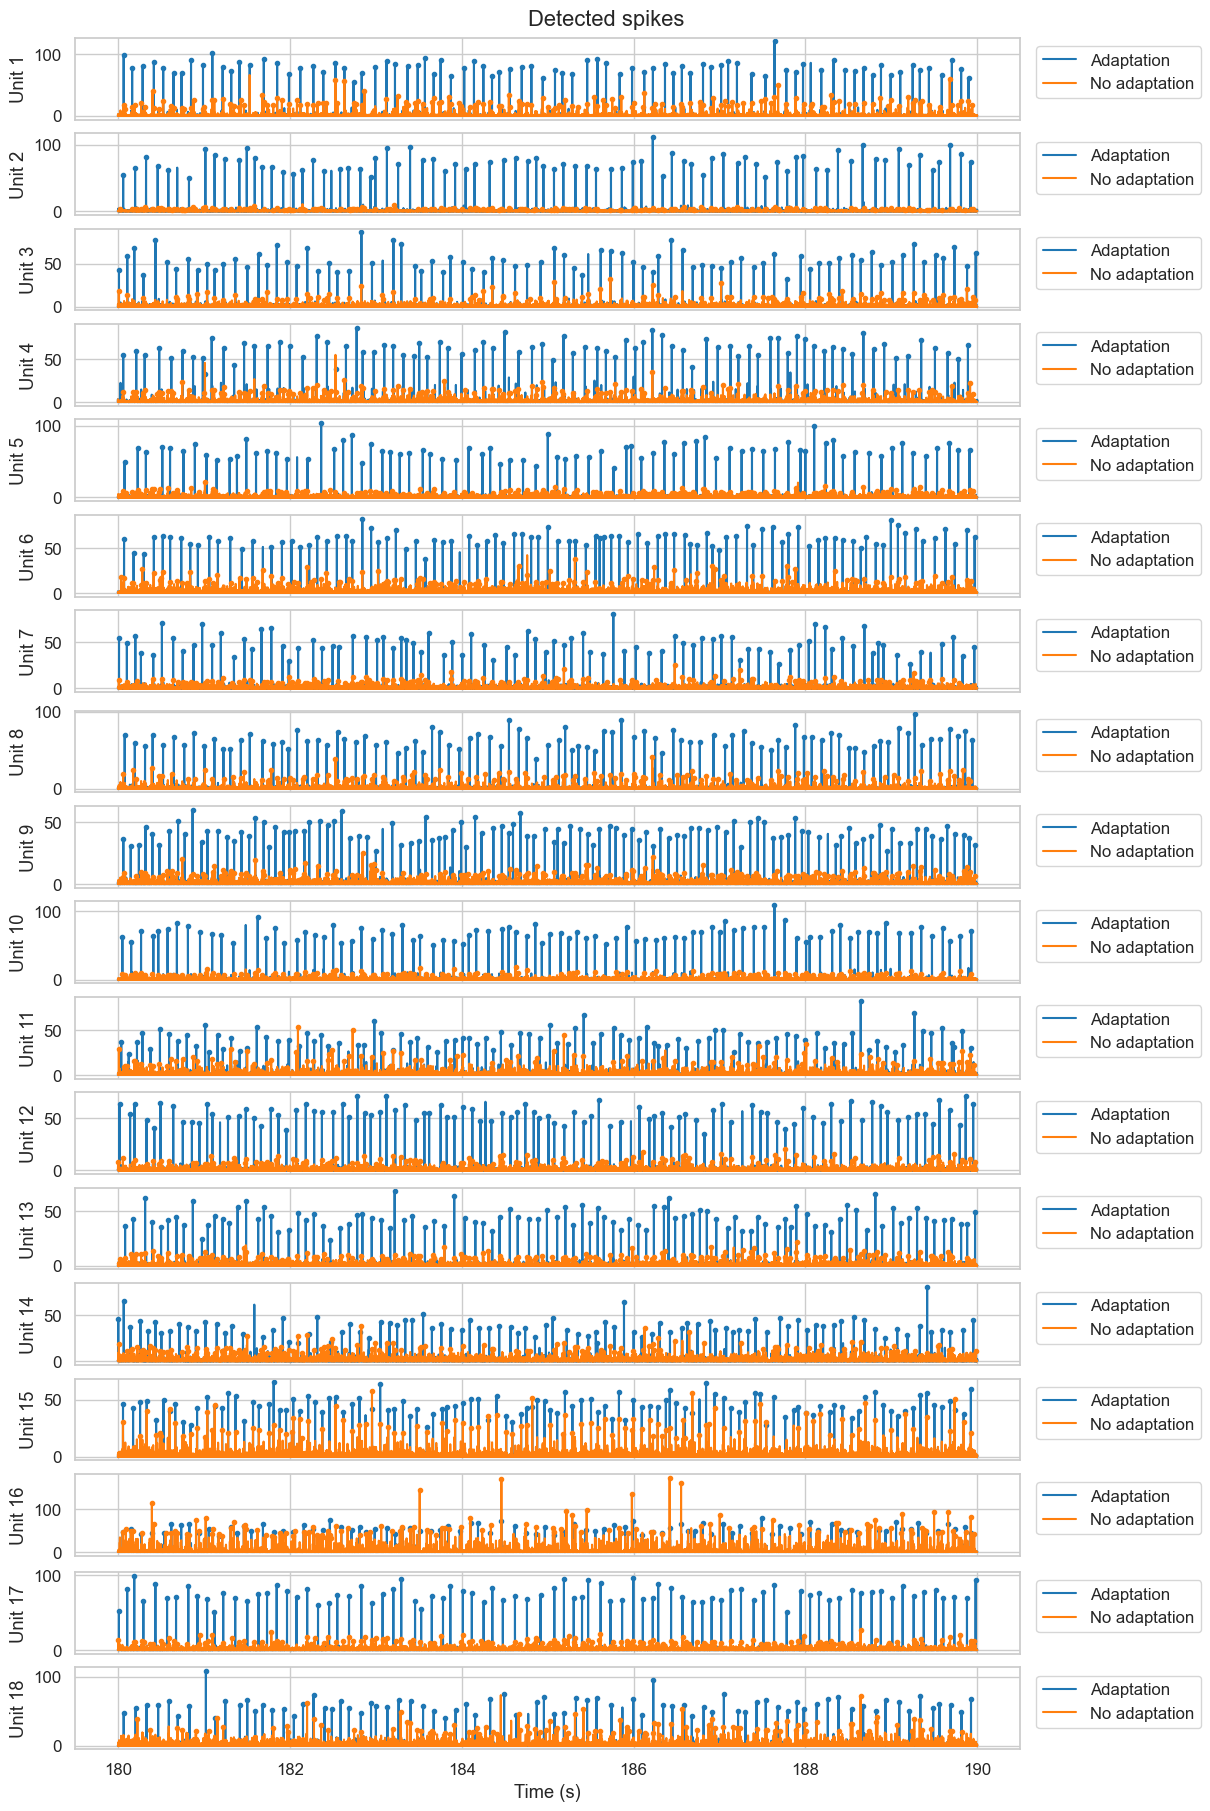

In [9]:
units = len(data['spikes_centr'])
time_window = [180, 190]
idxs = np.arange(time_window[0]*2048, time_window[1]*2048).astype(int)
plot_ipts = True

fig, axs = plt.subplots(units, 1, figsize=(12, units), layout='constrained', sharex=True)

for unit in range(units):
    if plot_ipts:
        axs[unit].plot(data['timestamps'][idxs], outputs_adapt['ipts'][idxs,unit] ** 2, label='Adaptation', color=colors[1])
    spikes_times = data['timestamps'][idxs][outputs_adapt['spikes'][idxs, unit].to(dtype=bool)]
    spikes_height = outputs_adapt['ipts'][idxs, unit][outputs_adapt['spikes'][idxs, unit].to(dtype=bool)] ** 2
    axs[unit].plot(spikes_times, spikes_height, linestyle='None', marker='.', color=colors[1])
    
    if plot_ipts:
        axs[unit].plot(data['timestamps'][idxs], outputs_no_adapt['ipts'][idxs,unit] ** 2, label='No adaptation', color=colors[0])
    spikes_times = data['timestamps'][idxs][outputs_no_adapt['spikes'][idxs, unit].to(dtype=bool)]
    spikes_height = outputs_no_adapt['ipts'][idxs, unit][outputs_no_adapt['spikes'][idxs, unit].to(dtype=bool)] ** 2
    axs[unit].plot(spikes_times, spikes_height, linestyle='None', marker='.', color=colors[0])

    axs[unit].set(ylabel=f'Unit {unit+1}') 
    if plot_ipts:
        axs[unit].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    if unit == units-1:
        axs[unit].set(xlabel='Time (s)')

plt.suptitle('Detected spikes')
plt.show()


## 7. Compute rate of agreement with ground truth
Since the dataset is simulated we can compute the rate of agreement between the ground truth and the detected spikes. To match the detected to the simulated ones we will use the calibration segment data (first 30s) only.

In [10]:
# Compute rate of agreement over the calibration phase only
idxs = np.arange(0, 30 * 2048).astype(int)

roa_no_adapt, pair_no_adapt, lag_no_adapt = rate_of_agreement(data['spikes_gt'].numpy()[idxs], outputs_no_adapt['spikes'].numpy()[idxs], fs=data['fs'])
roa_adapt, pair_adapt, lag_adapt = rate_of_agreement(data['spikes_gt'].numpy()[idxs], outputs_adapt['spikes'].numpy()[idxs], fs=data['fs'])

print(f'Rate of agreement (no adaptation): {roa_no_adapt.mean()*100:.2f} ± {roa_no_adapt.std()*100:.2f} (med: {np.median(roa_no_adapt)*100:.2f}) %')
print(f'Rate of agreement (adaptation): {roa_adapt.mean()*100:.2f} ± {roa_adapt.std()*100:.2f} (med: {np.median(roa_adapt)*100:.2f}) %')

# Make sure the pairs are the same
pair_adapt_array = np.array(pair_adapt)
pair_no_adapt_array = np.array(pair_no_adapt)
print(f'Same matched units: {np.all(pair_no_adapt_array[:, 0] == pair_adapt_array[:, 0])}')

Rate of agreement (no adaptation): 98.88 ± 0.61 (med: 98.88) %
Rate of agreement (adaptation): 98.66 ± 0.86 (med: 98.79) %
Same matched units: True


Now let's compute the rate of agreement for the detected spikes over the whole recording.

Rate of agreement (no adaptation): 44.31 ± 22.74 (med: 39.37) %
Rate of agreement (adaptation): 90.25 ± 19.93 (med: 98.58) %


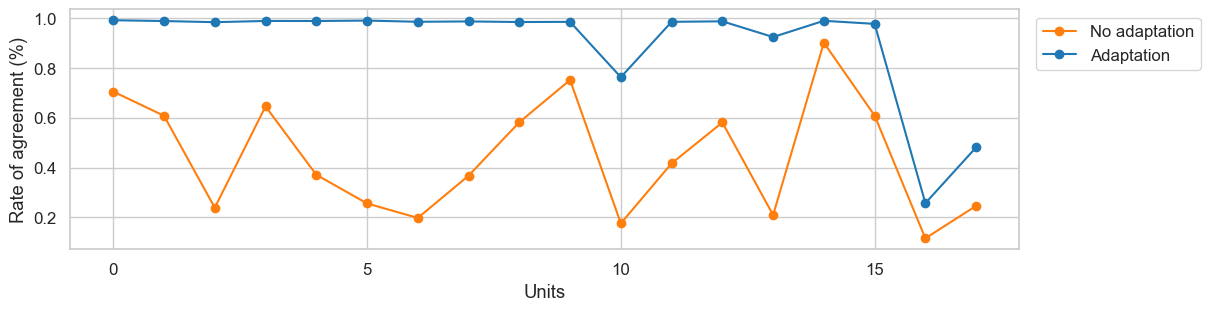

In [11]:
# Get simulated spikes
sim_spikes = data['spikes_gt'].numpy()[:, pair_no_adapt_array[:, 0]]

# Compute rate of agreement
roa_no_adapt, pair_no_adapt, lag_no_adapt = rate_of_agreement_paired(sim_spikes, outputs_no_adapt['spikes'].numpy(), fs=data['fs'], tol_spike_ms=2)
roa_adapt, pair_adapt, lag_adapt = rate_of_agreement_paired(sim_spikes, outputs_adapt['spikes'].numpy(), fs=data['fs'], tol_spike_ms=2)

print(f'Rate of agreement (no adaptation): {roa_no_adapt.mean()*100:.2f} ± {roa_no_adapt.std()*100:.2f} (med: {np.median(roa_no_adapt)*100:.2f}) %')
print(f'Rate of agreement (adaptation): {roa_adapt.mean()*100:.2f} ± {roa_adapt.std()*100:.2f} (med: {np.median(roa_adapt)*100:.2f}) %')

# Plot results
colors = ['tab:orange', 'tab:blue']
fig, axs = plt.subplots(1, 1, figsize=(12, 3), layout='constrained')
axs.plot(roa_no_adapt, marker='o', label='No adaptation', color=colors[0])
axs.plot(roa_adapt, marker='o', label='Adaptation', color=colors[1])
axs.set(xlabel='Units', ylabel='Rate of agreement (%)', xticks=range(0, units,5))
axs.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

## 8.  Evaluate changes in the decomposition parameters
Here we plot the calibration and operational whitening matrices, as well as their difference to evaluate the effect of the adaptation. We can do the same for all the separation vectors. Note that the changes in the whitening appear mainly in the main diagonal, and that the separation vector changes are in the same order as the original ones.

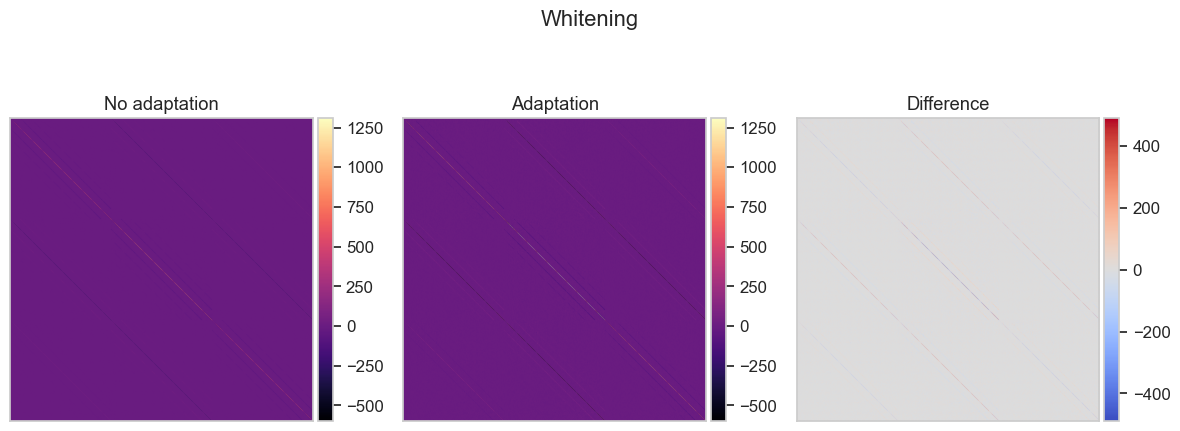

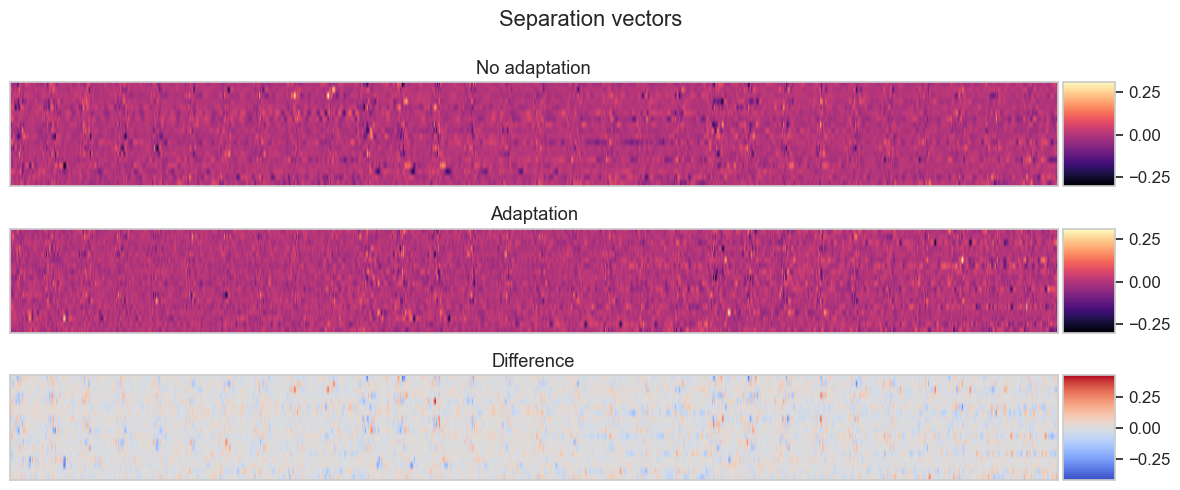

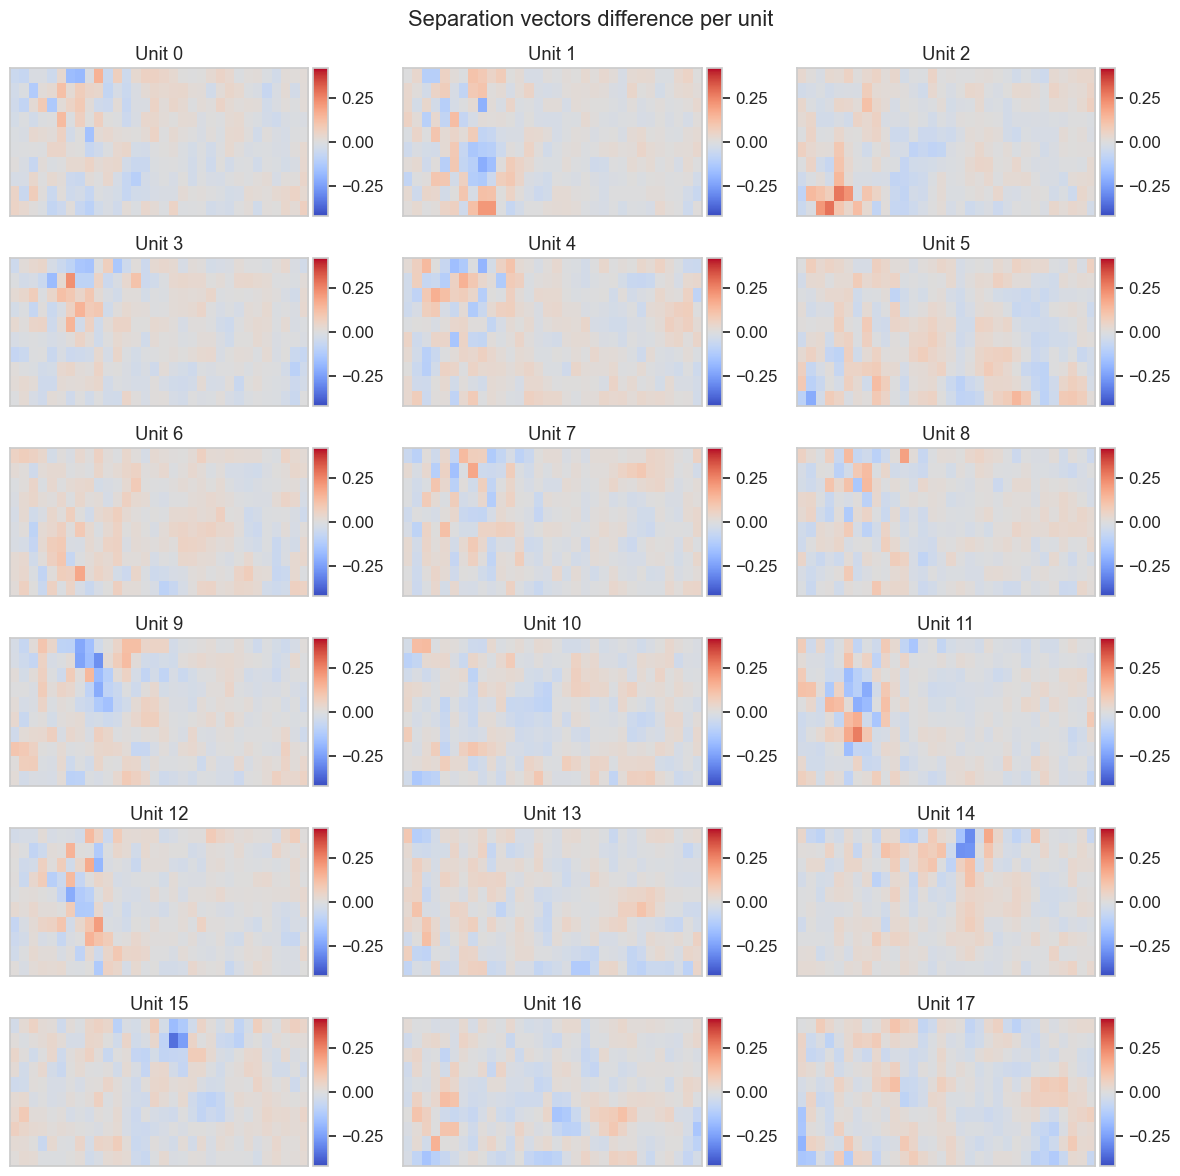

In [12]:
ax = plot_whitening_comp(data['whitening'].numpy(), dyndec_adapt.decomp.whitening.cpu().numpy())
ax[0].set(title='No adaptation')
ax[1].set(title='Adaptation')
plt.suptitle('Whitening')
plt.show()

ax = plot_sep_vectors_comp(data['sep_vectors'].numpy(), dyndec_adapt.decomp.sep_vectors.cpu().numpy())
ax[0].set(title='No adaptation')
ax[1].set(title='Adaptation')
plt.suptitle('Separation vectors')
plt.show()

ax = plot_sep_vectors_diff(data['sep_vectors'].numpy() - dyndec_adapt.decomp.sep_vectors.cpu().numpy(), data['ch_map'])
plt.suptitle('Separation vectors difference per unit')
plt.show()